In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load

In [82]:
sall = pd.read_csv("results_final/stats_by_slots.csv")
sc_agg = pd.read_csv("results_final/stats.csv")
display(sall.head())
display(sc_agg)

,benchmark,compilation id,closure,non-empty,read,used,exact match,widened,narrowed,checkForT,staticT,feedbackT,expectedT,requiredT,optimized away,dependent,polymorphic
0,areWeFast:Bounce_nonames_simple,0,match,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,1
1,areWeFast:Bounce_nonames_simple,0,match,1,1,1,0,1,0,val-,val+,(int|str)-,(int|str)-,val?+,0,0,1
2,areWeFast:Bounce_nonames_simple,0,match,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,0
3,areWeFast:Bounce_nonames_simple,0,match,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,0
4,areWeFast:Bounce_nonames_simple,1,bitwAnd,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,1,0


,name,referenced,referenced non-empty,read non-empty,used,unused non-empty,present non-empty,exact match,widened,narrowed,optimized away non-empty,dependent,other reasons unused non-empty,polluted,used polluted,unused polluted,used polluted exact match,used polluted widened,used polluted narrowed,closure version compilations,closure version compilations using some type feedback,referenced non-empty / referenced,read non-empty / referenced,used / referenced,optimized away non-empty / unused non-empty,dependent / unused non-empty,other reasons unused non-empty / unused non-empty,polluted / referenced non-empty,unused polluted / unused non-empty,used polluted / used,used polluted / polluted,used polluted exact match / exact match,used polluted widened / widened,used polluted narrowed / narrowed,used / referenced non-empty
0,areWeFast:Bounce_nonames_simple,264,160,117,12,148,77,7,5,0,71,128,9,16,3,13,0,3,0,11,7,0.781433,0.680735,0.172829,0.355792,0.556005,0.327005,0.220293,0.172798,0.333333,0.333333,0.000000,0.750000,0.000000,0.204793
1,shootout:binarytrees/binarytrees_naive,1070,341,218,83,258,112,56,27,0,146,213,33,72,21,51,4,17,0,22,13,0.565916,0.382067,0.113918,0.532638,0.606639,0.268119,0.205200,0.180770,0.336752,0.322500,0.074592,0.690476,0.000000,0.242096
2,shootout:knucleotide/knucleotide,1493,809,499,148,661,251,89,59,0,410,517,64,71,12,59,0,12,0,59,33,0.711240,0.562396,0.117276,0.537912,0.555019,0.209557,0.108234,0.087246,0.177082,0.223333,0.000000,0.252232,0.000000,0.164559
3,shootout:fasta/fasta_naive_2,598,343,251,73,270,111,44,29,0,159,225,19,23,5,18,0,5,0,17,11,0.742709,0.549981,0.126782,0.463718,0.565152,0.272775,0.088382,0.060171,0.164773,0.236607,0.000000,0.247619,0.000000,0.171056
4,shootout:fannkuch/fannkuchredux,251,184,165,5,179,64,4,1,0,115,163,8,6,1,5,0,1,0,6,3,0.701663,0.616824,0.082908,0.567955,0.619899,0.176717,0.120922,0.087626,0.333333,0.166667,0.000000,1.000000,0.000000,0.109883
5,shootout:pidigits/pidigits,5651,2774,2206,1000,1774,730,657,342,1,1044,1634,77,688,324,364,38,286,0,92,80,0.613941,0.495071,0.230395,0.548225,0.800988,0.138176,0.295624,0.306938,0.316609,0.475192,0.043608,0.755404,0.000000,0.374256
6,shootout:fannkuch/fannkuchredux_naive,244,164,144,3,161,52,2,1,0,109,145,8,6,1,5,0,1,0,5,2,0.719555,0.617660,0.065091,0.570241,0.524185,0.221241,0.151487,0.109877,0.500000,0.166667,0.000000,1.000000,0.000000,0.066259
7,areWeFast:Mandelbrot,358,280,213,24,256,117,14,10,0,139,233,10,19,4,15,0,4,0,14,9,0.843402,0.728668,0.161456,0.344474,0.689372,0.192308,0.209424,0.170797,0.194444,0.218750,0.000000,0.388889,0.000000,0.196470
8,RealThing:flexclust_no_s4,5335,2494,1814,701,1793,769,521,179,1,1024,1484,147,245,58,187,8,49,1,144,94,0.609136,0.520771,0.157897,0.435536,0.492764,0.325347,0.166014,0.145458,0.207183,0.247717,0.044435,0.353922,1.000000,0.266406
9,kaggle:titanic,66119,32697,22107,7017,25680,12094,4506,2501,16,13586,19658,3085,6290,1047,5243,272,767,14,2020,1234,0.656173,0.479126,0.116487,0.429915,0.577417,0.245014,0.242588,0.242474,0.214117,0.157414,0.081940,0.374887,0.928571,0.181532


In [83]:
columns_type = ["checkForT", "staticT", "feedbackT", "expectedT", "requiredT"]

In [84]:
if "benchmark" in sall.columns:
    sall.rename(columns={"benchmark": "name"}, inplace=True)

if "referenced" not in sall.columns:
    sall.insert(3, "referenced", pd.Series(1, index=sall.index))

if "closure" in sall.columns:
    sall.drop("closure", axis=1, inplace=True)

if "non-empty" in sall.columns:
    sall.rename(columns={"non-empty": "referenced non-empty"}, inplace=True)

In [85]:
# Add columns
sall_ne = sall["referenced non-empty"]

# Non-empty
sall["read non-empty"] = sall["read"] & sall_ne
assert (((sall["used"] & sall_ne) | (sall["used"] ^ 1))).all()

# Unused
sall["unused"] = sall["used"] ^ 1
sall["unused non-empty"] = sall["unused"] & sall_ne

sall["optimized away non-empty"] = sall["optimized away"] & sall_ne
# Fix dependent, TODO: turn to assert
sall["dependent"] = sall["dependent"] & sall_ne
sall["other reason unused non-empty"] = sall["unused"] & sall_ne & (sall["optimized away"] ^ 1) & (sall["dependent"] ^ 1)
sall["optimized away dependent"] = sall["optimized away non-empty"] & sall["dependent"]

# Used
sall["polymorphic used"] = sall["used"] & sall["polymorphic"]
sall["polymorphic exact match"] = sall["exact match"] & sall["polymorphic"]
sall["polymorphic widened"] = sall["widened"] & sall["polymorphic"]
sall["polymorphic narrowed"] = sall["narrowed"] & sall["polymorphic"]

# Unused polymorphic
sall["polymorphic unused"] = sall["unused"] & sall["polymorphic"]
sall["polymorphic optimized away non-empty"] = sall["optimized away non-empty"] & sall["polymorphic"]
sall["polymorphic dependent"] = sall["dependent"] & sall["polymorphic"]
sall["polymorphic other reason unused non-empty"] = sall["other reason unused non-empty"] & sall["polymorphic"]

sall["monomorphic"] = (sall["polymorphic"] ^ 1) & sall_ne

# Used monomorphic
sall["monomorphic used"] = sall["used"] & sall["monomorphic"]
sall["monomorphic exact match"] = sall["monomorphic used"] & sall["exact match"]
sall["monomorphic narrowed"] = sall["monomorphic used"] & sall["narrowed"]
sall["monomorphic widened"] = sall["monomorphic used"] & sall["widened"]

# Unused monomorphic
sall["monomorphic unused"] = sall["unused"] & sall["monomorphic"]
sall["monomorphic optimized away non-empty"] = sall["optimized away non-empty"] & sall["monomorphic"]
sall["monomorphic dependent"] = sall["dependent"] & sall["monomorphic"]
sall["monomorphic other reason unused non-empty"] = sall["other reason unused non-empty"] & sall["monomorphic"]
sall.head()

,name,compilation id,referenced,referenced non-empty,read,used,exact match,widened,narrowed,checkForT,staticT,feedbackT,expectedT,requiredT,optimized away,dependent,polymorphic,read non-empty,unused,unused non-empty,optimized away non-empty,other reason unused non-empty,optimized away dependent,polymorphic used,polymorphic exact match,polymorphic widened,polymorphic narrowed,polymorphic unused,polymorphic optimized away non-empty,polymorphic dependent,polymorphic other reason unused non-empty,monomorphic,monomorphic used,monomorphic exact match,monomorphic narrowed,monomorphic widened,monomorphic unused,monomorphic optimized away non-empty,monomorphic dependent,monomorphic other reason unused non-empty
0,areWeFast:Bounce_nonames_simple,0,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,areWeFast:Bounce_nonames_simple,0,1,1,1,1,0,1,0,val-,val+,(int|str)-,(int|str)-,val?+,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,areWeFast:Bounce_nonames_simple,0,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
3,areWeFast:Bounce_nonames_simple,0,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
4,areWeFast:Bounce_nonames_simple,1,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,1,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0


In [86]:
stats = sall.drop(columns_type + ["compilation id"], axis=1).groupby("name").sum()

# Split name
stats.reset_index(inplace=True)
stats[["set", "name"]] = stats["name"].str.split(":", expand=True)

# Sort
stats.sort_values(by=["set", "name"], inplace=True, key= lambda x: x.str.lower())

# Set new index
stats.set_index("name", inplace=True)
stats.insert(0, "set", stats.pop("set"))

# move Titanic to end
if "titanic" in stats.index:
    stats = pd.concat([stats.drop("titanic"), stats.loc[["titanic"]]])

stats

,set,referenced,referenced non-empty,read,used,exact match,widened,narrowed,optimized away,dependent,polymorphic,read non-empty,unused,unused non-empty,optimized away non-empty,other reason unused non-empty,optimized away dependent,polymorphic used,polymorphic exact match,polymorphic widened,polymorphic narrowed,polymorphic unused,polymorphic optimized away non-empty,polymorphic dependent,polymorphic other reason unused non-empty,monomorphic,monomorphic used,monomorphic exact match,monomorphic narrowed,monomorphic widened,monomorphic unused,monomorphic optimized away non-empty,monomorphic dependent,monomorphic other reason unused non-empty
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bounce_nonames_simple,areWeFast,264,160,124,12,7,5,0,175,128,16,117,252,148,71,9,60,3,0,3,0,13,6,9,3,144,9,7,0,2,135,65,119,6
Mandelbrot,areWeFast,358,280,222,24,14,10,0,217,233,19,213,334,256,139,10,126,4,0,4,0,15,9,7,3,261,20,14,0,6,241,130,226,7
flexclust_no_s4,RealThing,5335,2494,2151,701,521,179,1,3865,1484,245,1814,4634,1793,1024,147,862,58,8,49,1,187,99,135,35,2249,643,513,0,130,1606,925,1349,112
volcano,RealThing,2037,507,488,119,107,12,0,1763,354,17,465,1918,388,233,17,216,3,0,3,0,14,4,10,2,490,116,107,0,9,374,229,344,15
binarytrees/binarytrees_naive,shootout,1070,341,356,83,56,27,0,875,213,72,218,987,258,146,33,134,21,4,17,0,51,26,43,6,269,62,52,0,10,207,120,170,27
fannkuch/fannkuchredux,shootout,251,184,167,5,4,1,0,182,163,6,165,246,179,115,8,107,1,0,1,0,5,2,0,3,178,4,4,0,0,174,113,163,5
fannkuch/fannkuchredux_naive,shootout,244,164,144,3,2,1,0,189,145,6,144,241,161,109,8,101,1,0,1,0,5,2,0,3,158,2,2,0,0,156,107,145,5
fasta/fasta_naive_2,shootout,598,343,256,73,44,29,0,414,225,23,251,525,270,159,19,133,5,0,5,0,18,13,5,4,320,68,44,0,24,252,146,220,15
knucleotide/knucleotide,shootout,1493,809,561,148,89,59,0,1094,517,71,499,1345,661,410,64,330,12,0,12,0,59,35,32,12,738,136,89,0,47,602,375,485,52


# Aggregate

In [87]:
scomps = sall.drop(["checkForT", "staticT", "feedbackT", "expectedT", "requiredT"], axis=1).groupby(["name", "compilation id"]).sum()

scomps.reset_index(inplace=True)
scomps["name"] = scomps["name"].str.split(":", expand=True)[1]

scomps.head()

,name,compilation id,referenced,referenced non-empty,read,used,exact match,widened,narrowed,optimized away,dependent,polymorphic,read non-empty,unused,unused non-empty,optimized away non-empty,other reason unused non-empty,optimized away dependent,polymorphic used,polymorphic exact match,polymorphic widened,polymorphic narrowed,polymorphic unused,polymorphic optimized away non-empty,polymorphic dependent,polymorphic other reason unused non-empty,monomorphic,monomorphic used,monomorphic exact match,monomorphic narrowed,monomorphic widened,monomorphic unused,monomorphic optimized away non-empty,monomorphic dependent,monomorphic other reason unused non-empty
0,flexclust_no_s4,0,4,4,4,2,0,2,0,1,0,2,4,2,2,1,1,0,2,0,2,0,0,0,0,0,2,0,0,0,0,2,1,0,1
1,flexclust_no_s4,1,8,8,8,2,1,1,0,3,0,4,8,6,6,3,3,0,1,0,1,0,3,1,0,2,4,1,1,0,0,3,2,0,1
2,flexclust_no_s4,2,83,30,20,10,8,2,0,65,14,2,19,73,20,12,2,8,0,0,0,0,2,2,0,0,28,10,8,0,2,18,10,14,2
3,flexclust_no_s4,3,27,21,14,4,1,3,0,15,15,2,14,23,17,9,0,7,1,0,1,0,1,0,1,0,19,3,1,0,2,16,9,14,0
4,flexclust_no_s4,4,3,1,1,0,0,0,0,2,0,0,1,3,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


In [88]:
def agg(lhs, rhs):
    res_name = lhs + " / " + rhs
    if res_name not in stats:
        scomps[res_name] = scomps[lhs] / scomps[rhs]
        stats[res_name] = scomps.groupby("name")[res_name].mean()
    return stats[res_name]

agg("referenced non-empty", "referenced")

name
Bounce_nonames_simple            0.781433
Mandelbrot                       0.843402
flexclust_no_s4                  0.609136
volcano                          0.551936
binarytrees/binarytrees_naive    0.565916
fannkuch/fannkuchredux           0.701663
fannkuch/fannkuchredux_naive     0.719555
fasta/fasta_naive_2              0.742709
knucleotide/knucleotide          0.711240
pidigits/pidigits                0.613941
titanic                          0.656173
Name: referenced non-empty / referenced, dtype: float64

In [89]:
def agg_concat(*cols):
    return pd.concat([*cols], axis=1)

# C++ Aggregate

In [90]:
if "set" not in sc_agg.columns:
    sc_agg[["set", "name"]] = sc_agg["name"].str.split(":", expand=True)
    sc_agg.set_index("name", inplace=True)

if "compilations" not in stats.columns:
    stats.insert(1, "compilations",  sc_agg["closure version compilations"])

if "benefited" not in stats.columns:
    stats.insert(2, "benefited",  sc_agg["closure version compilations using some type feedback"])

stats

,set,compilations,benefited,referenced,referenced non-empty,read,used,exact match,widened,narrowed,optimized away,dependent,polymorphic,read non-empty,unused,unused non-empty,optimized away non-empty,other reason unused non-empty,optimized away dependent,polymorphic used,polymorphic exact match,polymorphic widened,polymorphic narrowed,polymorphic unused,polymorphic optimized away non-empty,polymorphic dependent,polymorphic other reason unused non-empty,monomorphic,monomorphic used,monomorphic exact match,monomorphic narrowed,monomorphic widened,monomorphic unused,monomorphic optimized away non-empty,monomorphic dependent,monomorphic other reason unused non-empty,referenced non-empty / referenced
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bounce_nonames_simple,areWeFast,11,7,264,160,124,12,7,5,0,175,128,16,117,252,148,71,9,60,3,0,3,0,13,6,9,3,144,9,7,0,2,135,65,119,6,0.781433
Mandelbrot,areWeFast,14,9,358,280,222,24,14,10,0,217,233,19,213,334,256,139,10,126,4,0,4,0,15,9,7,3,261,20,14,0,6,241,130,226,7,0.843402
flexclust_no_s4,RealThing,144,94,5335,2494,2151,701,521,179,1,3865,1484,245,1814,4634,1793,1024,147,862,58,8,49,1,187,99,135,35,2249,643,513,0,130,1606,925,1349,112,0.609136
volcano,RealThing,23,16,2037,507,488,119,107,12,0,1763,354,17,465,1918,388,233,17,216,3,0,3,0,14,4,10,2,490,116,107,0,9,374,229,344,15,0.551936
binarytrees/binarytrees_naive,shootout,22,13,1070,341,356,83,56,27,0,875,213,72,218,987,258,146,33,134,21,4,17,0,51,26,43,6,269,62,52,0,10,207,120,170,27,0.565916
fannkuch/fannkuchredux,shootout,6,3,251,184,167,5,4,1,0,182,163,6,165,246,179,115,8,107,1,0,1,0,5,2,0,3,178,4,4,0,0,174,113,163,5,0.701663
fannkuch/fannkuchredux_naive,shootout,5,2,244,164,144,3,2,1,0,189,145,6,144,241,161,109,8,101,1,0,1,0,5,2,0,3,158,2,2,0,0,156,107,145,5,0.719555
fasta/fasta_naive_2,shootout,17,11,598,343,256,73,44,29,0,414,225,23,251,525,270,159,19,133,5,0,5,0,18,13,5,4,320,68,44,0,24,252,146,220,15,0.742709
knucleotide/knucleotide,shootout,59,33,1493,809,561,148,89,59,0,1094,517,71,499,1345,661,410,64,330,12,0,12,0,59,35,32,12,738,136,89,0,47,602,375,485,52,0.711240


# Plot

In [91]:
def plot(df: pd.DataFrame, index, columns = None,
         title = None, filename = None,
         figsize= (15, 5), colors = None,
         labels = None, legend = None,
         xlabel = None, ylabel = None):
    if columns is None:
        columns = df.columns
    else:
        df = df[columns]

    df = df.copy()
    df.index = index

    ax = df.plot(
        kind="bar",
        width=0.75,
        figsize=figsize,
        color=colors
    )

    if labels == "values":
        labels = [df[col].round(2) for col in columns]

    if labels is not None:
        for container, l in zip(ax.containers, labels):
            ax.bar_label(container, labels=l, label_type="edge", padding=2)

    if legend is not None:
        plt.legend(legend, loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=len(df.columns))

    if title is not None:
        plt.title(title)

    if xlabel is not None:
        plt.xlabel(xlabel)

    if ylabel is not None:
        plt.ylabel(ylabel)

    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)

    if filename is not None:
        plt.savefig("./figures/" + filename + ".pdf", bbox_inches='tight')

    plt.show()

In [92]:
figsize_three_cols = (18, 5)

## Usage of slots

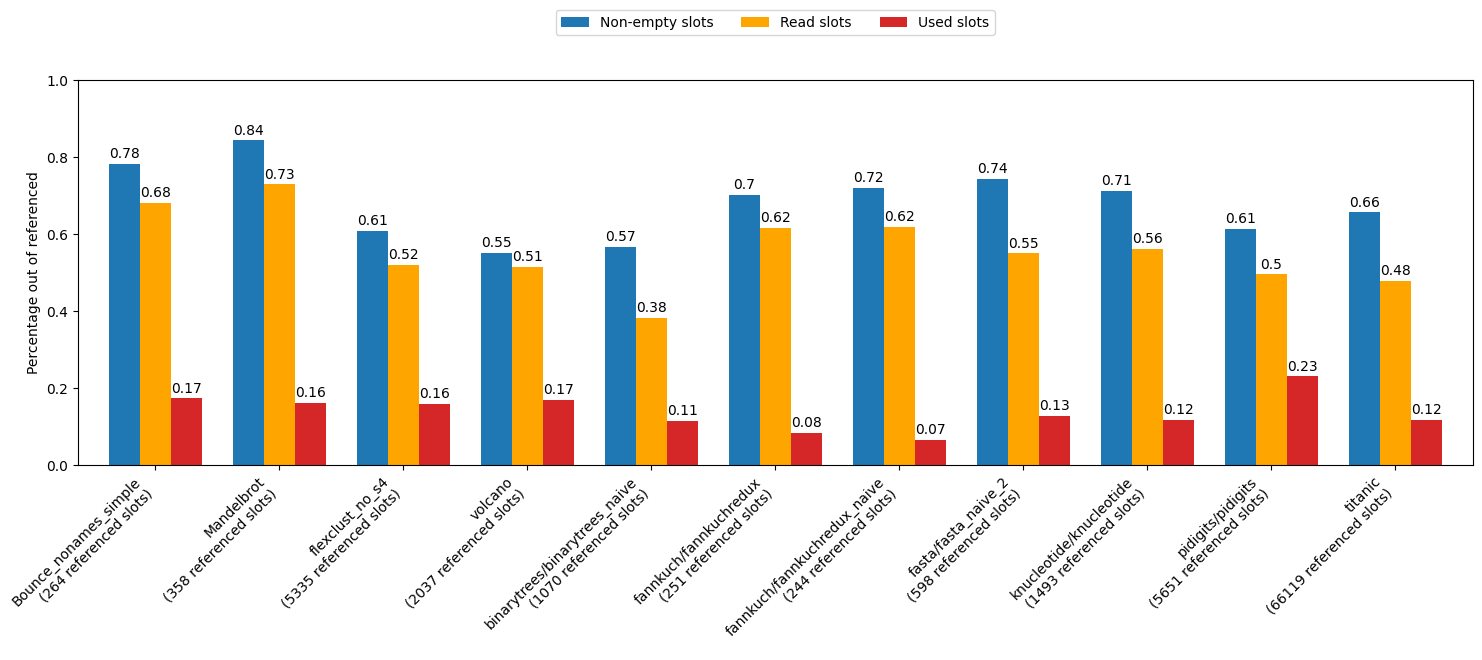

In [93]:
colors_usage =["tab:blue", "orange", "tab:red"]

plot(
    agg_concat(
        agg("referenced non-empty", "referenced"),
        agg("read non-empty", "referenced"),
        agg("used", "referenced")
    ),

    index = stats.index + "\n(" + stats["referenced"].astype(str) + " referenced slots)",

    # title= "Usage of slots across closure compilations",

    colors=colors_usage,

    labels = "values",
    figsize=figsize_three_cols,

    legend=[
        "Non-empty slots",
        "Read slots",
        "Used slots"
    ],

    ylabel="Percentage out of referenced",

    filename="usage_overall"
)

In [94]:
# plot(
#     agg_concat(
#         (stats["referenced non-empty"] / stats["referenced"]),
#         (stats["read non-empty"] / stats["referenced"]),
#         (stats["used"] / stats["referenced"])
#     ),

#     index = stats.index + "\n(" + stats["referenced"].astype(str) + " referenced slots)",

#     # title= "Usage of slots across closure compilations",

#     colors=colors_usage,

#     labels = [stats["referenced non-empty"], stats["read non-empty"], stats["used"]],
#     figsize=figsize_three_cols,

#     legend=[
#         "% of non-empty slots (referenced non-empty / referenced)",
#         "% of read non-empty slots (read non-empty / referenced)",
#         "% of used non-empty slots (used / referenced)"
#     ],

#     ylabel="Percentage out of referenced",
# )

## Unused

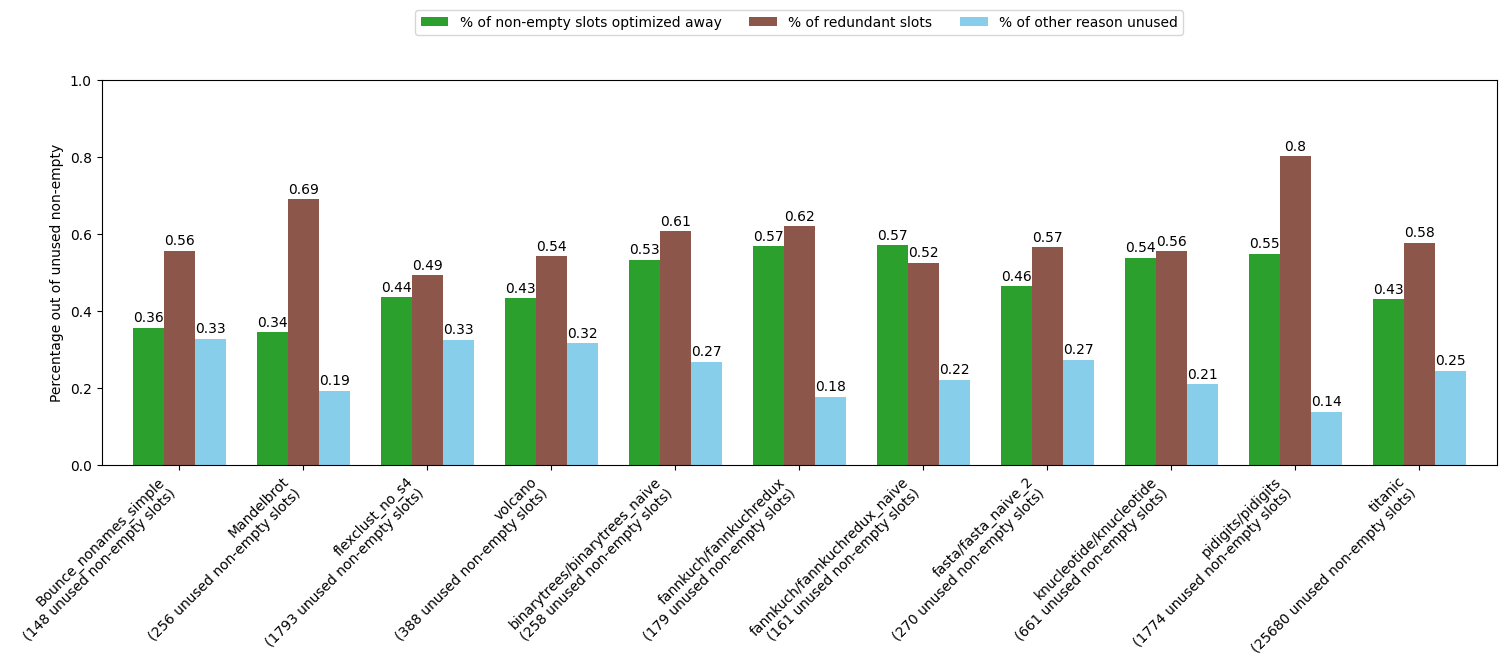

In [95]:
plot(
    agg_concat(
        agg("optimized away non-empty", "unused non-empty"),
        agg("dependent", "unused non-empty"),
        agg("other reason unused non-empty", "unused non-empty")
    ),

    index = stats.index + "\n(" + stats["unused non-empty"].astype(str) + " unused non-empty slots)",

    # title="Unused non-empty slots",

    colors=["tab:green", "tab:brown", "skyblue"],
    figsize=figsize_three_cols,

    labels= "values",
    legend=[
        "% of non-empty slots optimized away",
        "% of redundant slots",
        "% of other reason unused"
    ],

    ylabel="Percentage out of unused non-empty",
    filename="unused"
)

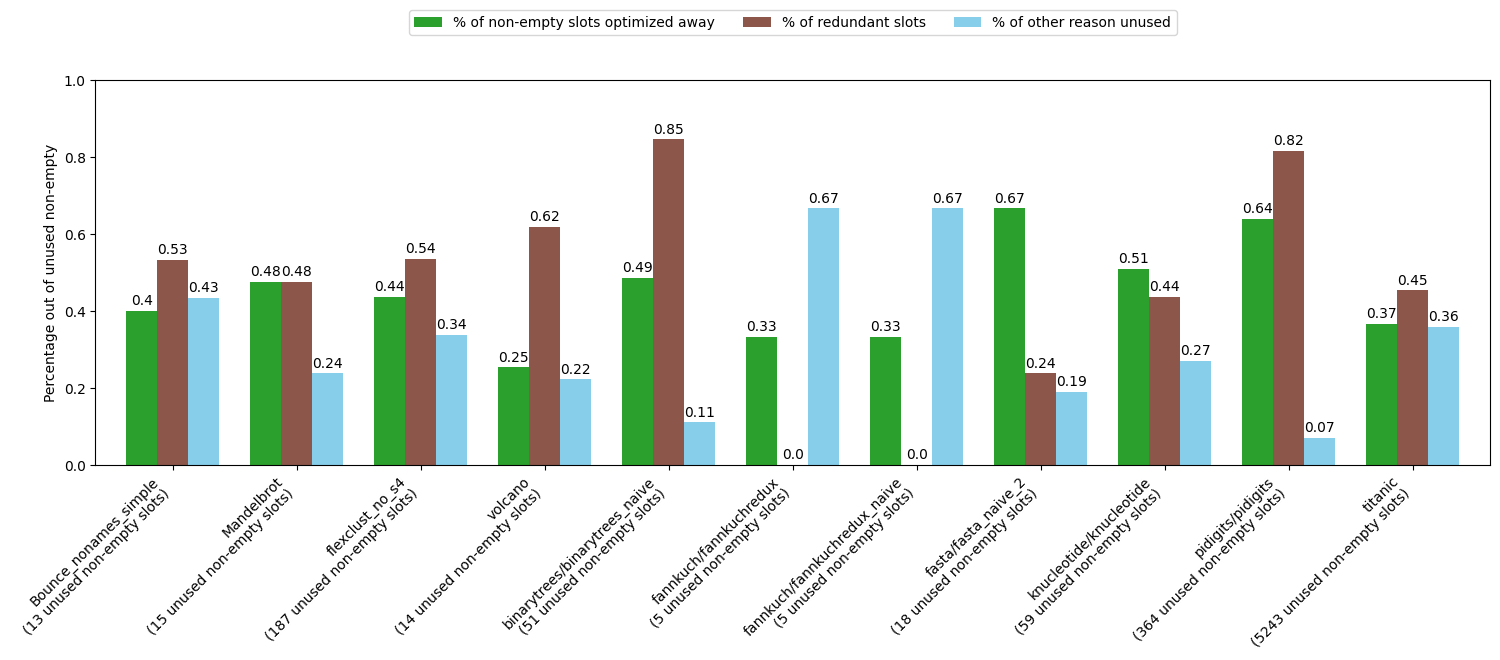

In [96]:
plot(
    agg_concat(
        agg("polymorphic optimized away non-empty", "polymorphic unused"),
        agg("polymorphic dependent", "polymorphic unused"),
        agg("polymorphic other reason unused non-empty", "polymorphic unused")
    ),

    index = stats.index + "\n(" + stats["polymorphic unused"].astype(str) + " unused non-empty slots)",

    # title="Unused non-empty slots",

    colors=["tab:green", "tab:brown", "skyblue"],
    figsize=figsize_three_cols,

    labels= "values",
    legend=[
        "% of non-empty slots optimized away",
        "% of redundant slots",
        "% of other reason unused"
    ],

    ylabel="Percentage out of unused non-empty",
    filename="unused"
)

In [ ]:
fig, ax = plt.subplots()



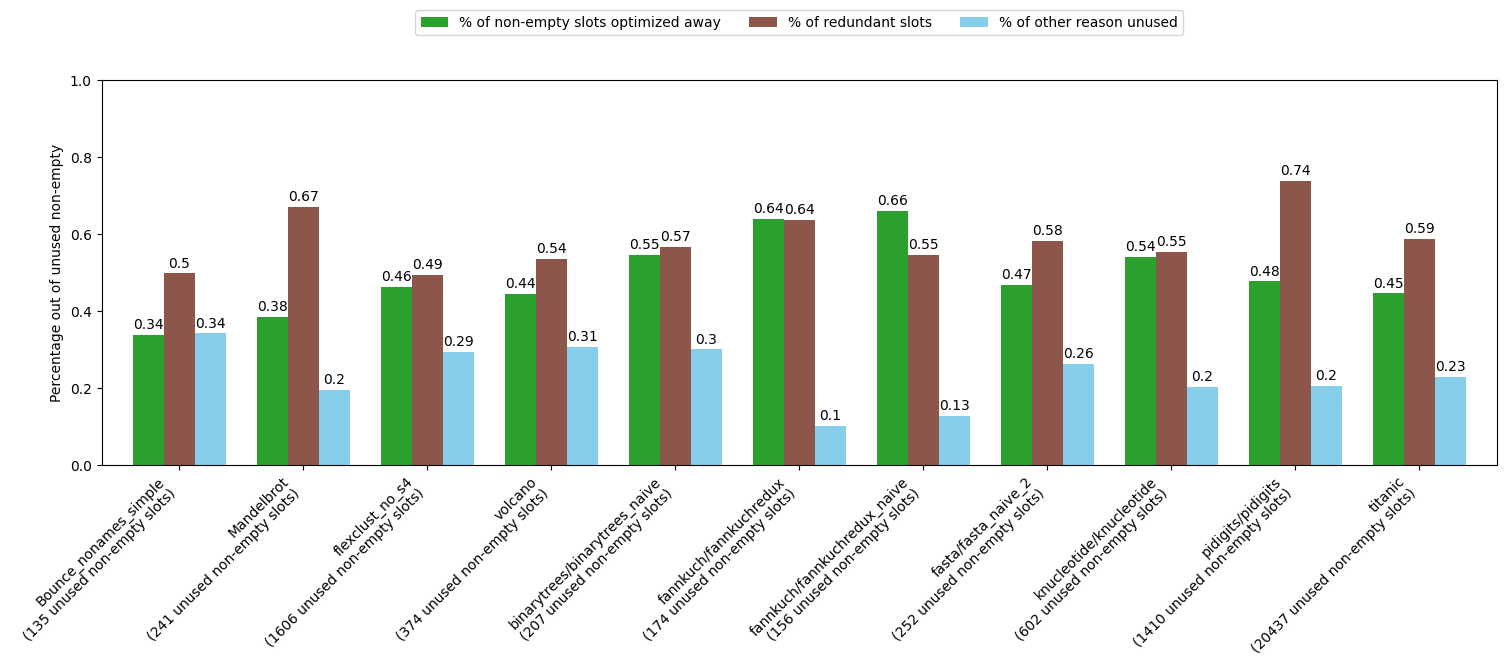

In [97]:
plot(
    agg_concat(
        agg("monomorphic optimized away non-empty", "monomorphic unused"),
        agg("monomorphic dependent", "monomorphic unused"),
        agg("monomorphic other reason unused non-empty", "monomorphic unused")
    ),

    index = stats.index + "\n(" + stats["monomorphic unused"].astype(str) + " unused non-empty slots)",

    # title="Unused non-empty slots",

    colors=["tab:green", "tab:brown", "skyblue"],
    figsize=figsize_three_cols,

    labels= "values",
    legend=[
        "% of non-empty slots optimized away",
        "% of redundant slots",
        "% of other reason unused"
    ],

    ylabel="Percentage out of unused non-empty",
    filename="unused"
)

## Unused slots

In [98]:
colors_used = ["cornflowerblue", "tomato", "gold"]

In [99]:
def compute_used_percentage(prefix=""):
    used_columns = [ prefix + c for c in ["exact match", "widened", "narrowed"]]
    used_columns_perc = [ c + " %" for c in used_columns ]

    for (uc, ucp) in zip(used_columns, used_columns_perc):
        stats[ucp] = stats[uc] / stats[ prefix + "used" ]

    return (used_columns, used_columns_perc)

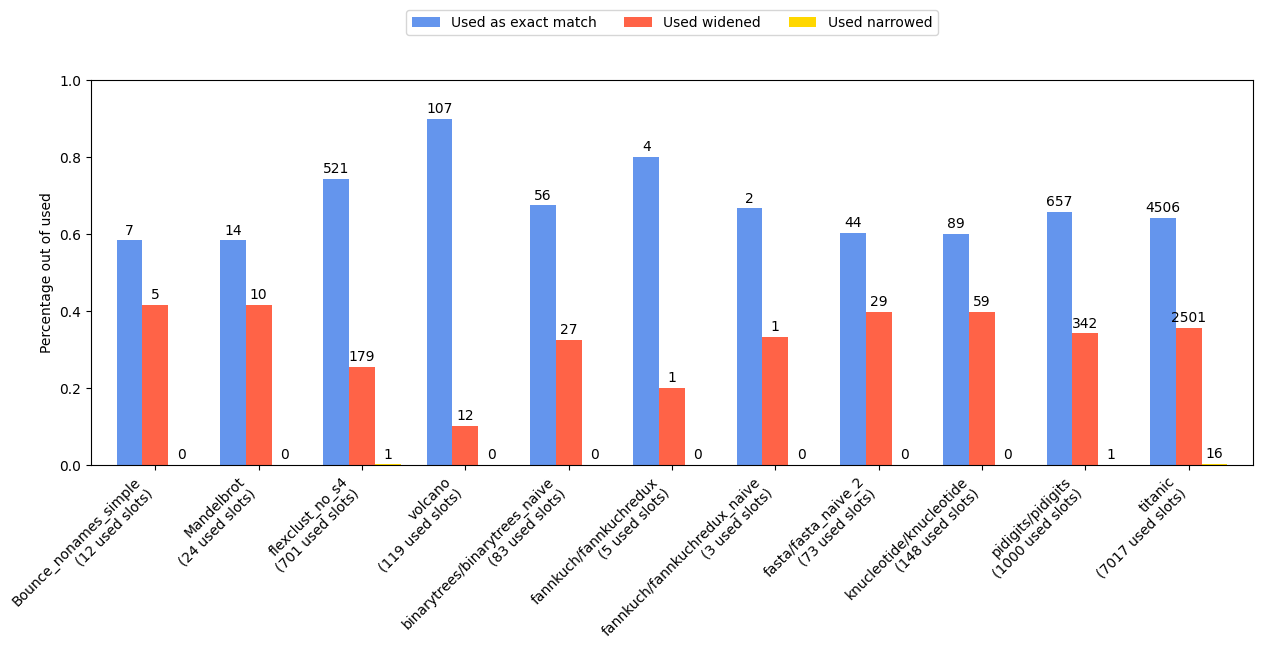

In [100]:
(u_col, u_col_p) = compute_used_percentage()

plot(stats,
    index=stats.index + "\n(" + stats["used"].astype(str) + " used slots)",
    columns=u_col_p,

    # title="Used slots",

    colors=colors_used,

    labels=[ stats[col] for col in u_col ],
    legend = ["Used as exact match", "Used widened", "Used narrowed"],

    ylabel="Percentage out of used",
    filename="used"
)

In [101]:
# plot(
#     agg_concat(
#         agg("exact match", "used"),
#         agg("widened", "used"),
#         agg("narrowed", "used"),
#     ),

#     index=stats.index + "\n(" + stats["used"].astype(str) + " used slots)",

#     # title="Used slots",

#     colors=colors_used,
#     figsize=figsize_three_cols,

#     labels="values",
#     legend = ["Used as exact match", "Used widened", "Used narrowed"],

#     ylabel="Percentage out of used",
#     filename="used"
# )

In [102]:
# plot(
#     agg_concat(
#         agg("polymorphic exact match", "used polymorphic"),
#         agg("polymorphic widened", "used polymorphic"),
#         agg("polymorphic narrowed", "used polymorphic"),
#     ),

#     index=stats.index + "\n(" + stats["used polymorphic"].astype(str) + " used polymorphic slots)",

#     # title="Used slots",
#     colors=colors_used,
#     figsize=figsize_three_cols,

#     labels="values",
#     legend = ["Polymorphic used as exact match", "Polymorphic used widened", "Polymorphic used narrowed"],

#     ylabel="Percentage out of used polymorphic",
#     filename="used_poly"
# )

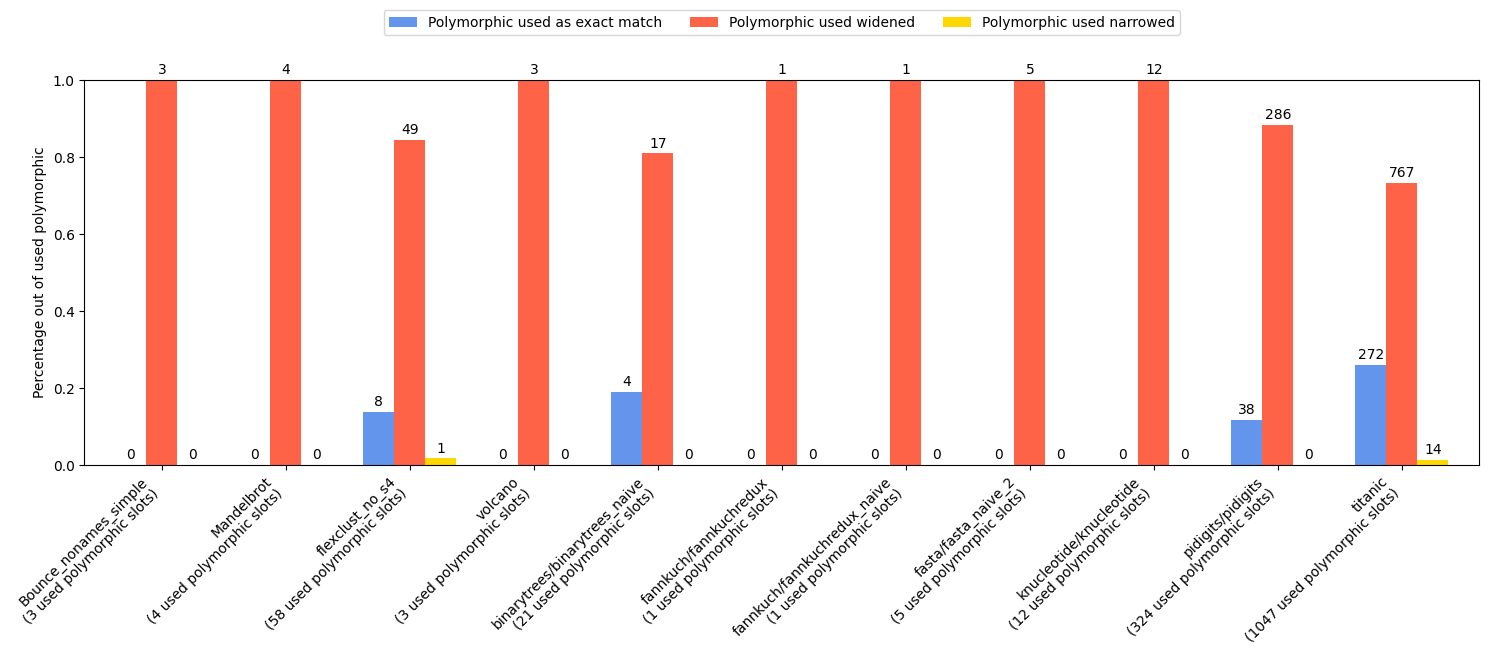

In [103]:
(pu_col, pu_col_p) = compute_used_percentage("polymorphic ")

plot(
    stats,

    index=stats.index + "\n(" + stats["polymorphic used"].astype(str) + " used polymorphic slots)",
    columns=pu_col_p,

    # title="Used slots",
    colors=colors_used,
    figsize=figsize_three_cols,

    labels=[stats[c] for c in pu_col],
    legend = ["Polymorphic used as exact match", "Polymorphic used widened", "Polymorphic used narrowed"],

    ylabel="Percentage out of used polymorphic",
    filename="used_poly"
)

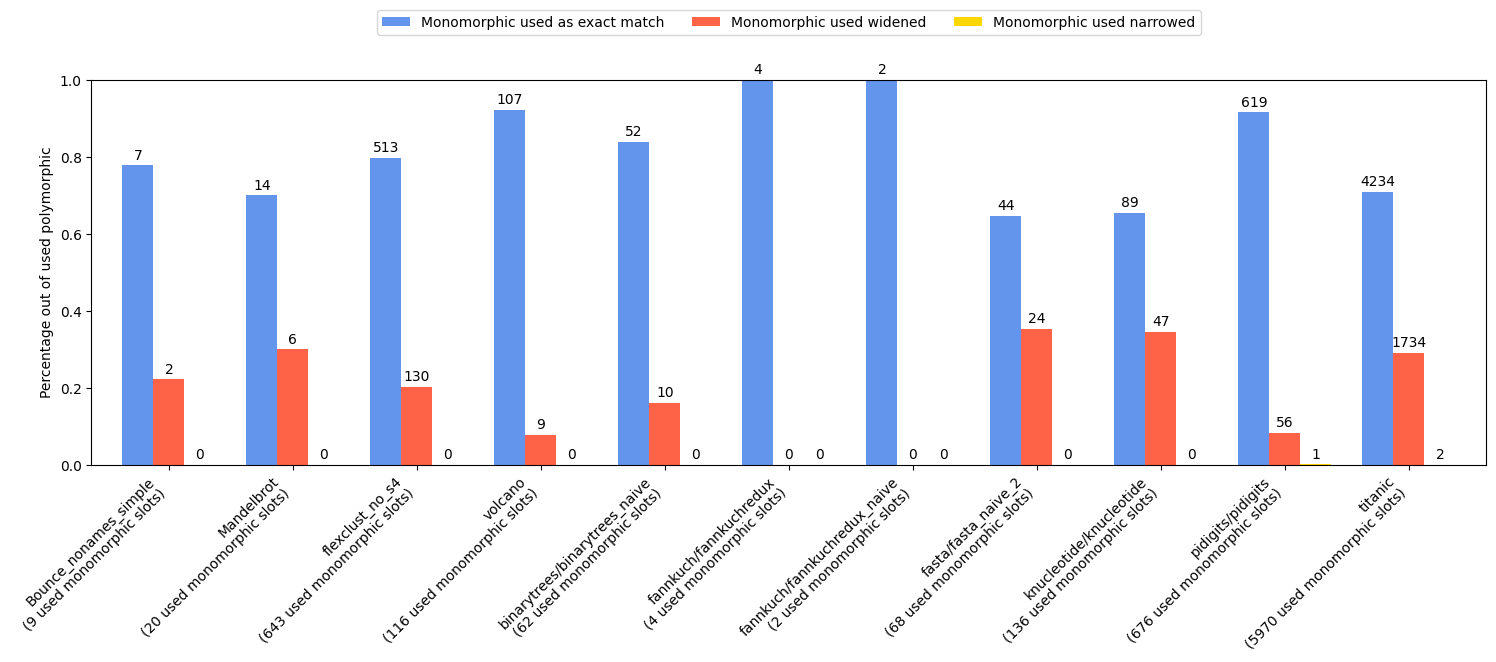

In [104]:
(mu_col, mu_col_p) = compute_used_percentage("monomorphic ")

plot(
    stats,

    index=stats.index + "\n(" + stats["monomorphic used"].astype(str) + " used monomorphic slots)",
    columns=mu_col_p,

    # title="Used slots",
    colors=colors_used,
    figsize=figsize_three_cols,

    labels=[stats[c] for c in mu_col],
    legend = ["Monomorphic used as exact match", "Monomorphic used widened", "Monomorphic used narrowed"],

    ylabel="Percentage out of used polymorphic",
    filename="used_mono"
)

# Other stats

## Overview

In [105]:
table = stats[["set", "compilations", "benefited", "referenced"]]
display(table)
table.to_latex('tables/table.tex')

,set,compilations,benefited,referenced
name,,,,
Bounce_nonames_simple,areWeFast,11,7,264
Mandelbrot,areWeFast,14,9,358
flexclust_no_s4,RealThing,144,94,5335
volcano,RealThing,23,16,2037
binarytrees/binarytrees_naive,shootout,22,13,1070
fannkuch/fannkuchredux,shootout,6,3,251
fannkuch/fannkuchredux_naive,shootout,5,2,244
fasta/fasta_naive_2,shootout,17,11,598
knucleotide/knucleotide,shootout,59,33,1493


## Usage

In [106]:
def m(lhs, rhs = None):
    if rhs is None:
        df = stats[[lhs]]
    else:
        df = pd.DataFrame(agg(lhs, rhs))

    display(df.describe().loc["mean"])

In [107]:
m("referenced non-empty", "referenced")
m("read non-empty", "referenced non-empty")
m("used", "referenced")
m("used", "referenced non-empty")

referenced non-empty / referenced    0.681555
Name: mean, dtype: float64

read non-empty / referenced non-empty    0.81185
Name: mean, dtype: float64

used / referenced    0.137644
Name: mean, dtype: float64

used / referenced non-empty    0.208028
Name: mean, dtype: float64

In [108]:
m("read non-empty", "referenced non-empty")

read non-empty / referenced non-empty    0.81185
Name: mean, dtype: float64

## Unused

In [ ]:
m("optimized away non-empty", "unused non-empty")
m("dependent", "unused non-empty")
m("other reason unused non-empty", "unused non-empty")
m("optimized away dependent", "optimized away non-empty")
m("optimized away dependent", "dependent")
m("optimized away dependent", "unused non-empty")

optimized away non-empty / unused non-empty    0.474429
Name: mean, dtype: float64

dependent / unused non-empty    0.59354
Name: mean, dtype: float64

other reason unused non-empty / unused non-empty    0.244767
Name: mean, dtype: float64

optimized away dependent / optimized away non-empty    0.621494
Name: mean, dtype: float64

optimized away dependent / dependent    0.502184
Name: mean, dtype: float64

optimized away dependent / unused non-empty    0.312737
Name: mean, dtype: float64

In [119]:
m("polymorphic optimized away non-empty", "polymorphic unused"),
m("polymorphic dependent", "polymorphic unused"),
m("polymorphic other reason unused non-empty", "polymorphic unused")

polymorphic optimized away non-empty / polymorphic unused    0.445744
Name: mean, dtype: float64

polymorphic dependent / polymorphic unused    0.450491
Name: mean, dtype: float64

polymorphic other reason unused non-empty / polymorphic unused    0.324177
Name: mean, dtype: float64

In [120]:
m("monomorphic optimized away non-empty", "monomorphic unused"),
m("monomorphic dependent", "monomorphic unused"),
m("monomorphic other reason unused non-empty", "monomorphic unused")

monomorphic optimized away non-empty / monomorphic unused    0.49132
Name: mean, dtype: float64

monomorphic dependent / monomorphic unused    0.582631
Name: mean, dtype: float64

monomorphic other reason unused non-empty / monomorphic unused    0.233349
Name: mean, dtype: float64

## Used

In [110]:
stats["narrowed"].sum()

18

In [111]:
stats["polymorphic exact match"].sum()

322

In [112]:
m("exact match %")
m("widened %")
m("narrowed %")

m("monomorphic exact match %")

m("polymorphic widened %")
m("polymorphic exact match %")

exact match %    0.677606
Name: mean, dtype: float64

widened %    0.322044
Name: mean, dtype: float64

narrowed %    0.000428
Name: mean, dtype: float64

monomorphic exact match %    0.814826
Name: mean, dtype: float64

polymorphic widened %    0.933603
Name: mean, dtype: float64

polymorphic exact match %    0.064135
Name: mean, dtype: float64

In [113]:
m("exact match", "used")
m("widened", "used")
m("polymorphic widened", "widened")

exact match / used    0.594446
Name: mean, dtype: float64

widened / used    0.404398
Name: mean, dtype: float64

polymorphic widened / widened    0.551221
Name: mean, dtype: float64

## Polymorphic

In [114]:
polym = agg("polymorphic widened", "polymorphic used")
display(polym)
display(polym.mean())

name
Bounce_nonames_simple            1.000000
Mandelbrot                       1.000000
flexclust_no_s4                  0.806452
volcano                          1.000000
binarytrees/binarytrees_naive    0.918367
fannkuch/fannkuchredux           1.000000
fannkuch/fannkuchredux_naive     1.000000
fasta/fasta_naive_2              1.000000
knucleotide/knucleotide          1.000000
pidigits/pidigits                0.890203
titanic                          0.699500
Name: polymorphic widened / polymorphic used, dtype: float64

0.9376838058683965

In [115]:
m("used", "referenced non-empty")
m("polymorphic used", "polymorphic")

used / referenced non-empty    0.208028
Name: mean, dtype: float64

polymorphic used / polymorphic    0.260062
Name: mean, dtype: float64

# Types

In [116]:
sused = sall[sall["used"] == 1]

In [117]:
snarrowed = sused[sused["narrowed"] == 1][columns_type + ["polymorphic"]].value_counts().reset_index().sort_values(by=columns_type)
display(snarrowed["count"].sum())
snarrowed

18

,checkForT,staticT,feedbackT,expectedT,requiredT,polymorphic,count
2,int$#-,(int|real)$#-,int$-,int$#-,val?^ | miss,0,3
0,int$-,(int|real)$-,int-,int$-,val?+,1,4
3,real-,real+,(lgl|str)-,-,val?+,1,2
1,val-,val+,val?-,val-,val?+,1,4
6,val-,val+,val?-,val-,val?^ | miss,1,1
4,val?~+,val?^,val?+,val+,val?+,1,2
5,val?~-,val?^,val?-,val-,val?+,1,2


In [118]:
swidened_poly = sused[sused["polymorphic exact match"] == 1]["feedbackT"].value_counts().reset_index().sort_values(by="feedbackT")
swidened_poly

,feedbackT,count
2,int+,37
0,int-,124
6,lgl+,26
3,lgl-,33
7,real+,3
1,real-,39
5,val?+,30
4,val?-,30
